In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
import joblib
!pip install joblib

Test with champion model XGBoost

In [2]:
# Önceden eğitilmiş PCA ve XGBoost modellerinin yolları
pca_model_path = 'PCA_model.sav'
xgb_model_path = 'xgb.sav'

# Okunan resimlerin bulunduğu klasör yolu
folder_path = 'bad_results_for_method2'  # Klasör yolunu belirtin

# Yüklenen PCA modelini kullanarak boyut azaltma işlemi yapar
def apply_pca(features):
    pca = joblib.load(pca_model_path)
    features_pca = pca.transform(features)
    return features_pca

# Yüklenen XGBoost modelini kullanarak sınıflandırma yapar
def classify_with_xgb(features):
    loaded_model = joblib.load(xgb_model_path)
    predictions = loaded_model.predict(features)
    return predictions

# Klasördeki tüm resim dosyalarını okur
def read_images(folder_path):
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            image_paths.append(img_path)
    return image_paths

# Ana işlemleri gerçekleştirir
def process_images(image_paths):
    results = []
    for img_path in image_paths:
        # Resmi oku
        img = cv2.imread(img_path)

        # Yeniden boyutlandırma
        resized_img = cv2.resize(img, (200, 200))

        # Gri tonlama ve median bulanıklaştırma
        gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        median_img = cv2.medianBlur(gray, 3)

        # HOG özellik çıkarımı
        fd, hog_image = hog(median_img, orientations=6, pixels_per_cell=(4, 4), transform_sqrt=True, cells_per_block=(1, 1), visualize=True)

        # Özellikleri DataFrame formatına dönüştürme ve PCA'ya uygulama
        df = pd.DataFrame(fd)
        df_transposed = df.transpose()
        fd_pca = apply_pca(df_transposed)

        # Sınıflandırma yapma
        prediction = classify_with_xgb(fd_pca)

        results.append((img_path, prediction))

    return results

# Sonuçları yazdırma
def print_results(results):
    for img_path, prediction in results:
        if prediction == 0:
            print("File:", img_path, "Prediction: Glioma Tumor")
        elif prediction == 1:
            print("File:", img_path, "Prediction: Meningioma Tumor")
        elif prediction == 2:
            print("File:", img_path, "Prediction: No Tumor")
        elif prediction == 3:
            print("File:", img_path, "Prediction: Pituitary Tumor")

# Ana fonksiyon
def main():
    image_paths = read_images(folder_path)
    results = process_images(image_paths)
    print_results(results)

if __name__ == "__main__":
    main()

File: bad_results_for_method2\meningioma_tumor_and_result_is_wrong.jpg Prediction: Pituitary Tumor
File: bad_results_for_method2\no_tumor_and_ result_is_wrong.jpg Prediction: No Tumor


Confusion Matrix:
 [[1 0 0 0]
 [0 0 0 1]
 [0 0 2 0]
 [0 0 0 0]]
Accuracy: 0.75
Precision: 0.5
Recall: 0.5
F1 Score: 0.5


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


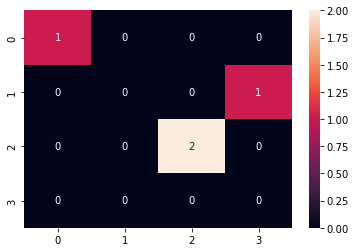

In [3]:
import os
import cv2
import joblib
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Önceden eğitilmiş PCA ve XGBoost modellerinin yolları
pca_model_path = 'PCA_model.sav'
xgb_model_path = 'xgb.sav'

# Okunan resimlerin bulunduğu klasör yolu
folder_path = 'test_jpegs'

def load_pca_model():
    pca = joblib.load(pca_model_path)
    return pca

def load_xgb_model():
    xgb = joblib.load(xgb_model_path)
    return xgb

def read_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (200, 200))
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    median_img = cv2.medianBlur(gray, 3)
    fd, _ = hog(median_img, orientations=6, pixels_per_cell=(4, 4), transform_sqrt=True, cells_per_block=(1, 1), visualize=True)
    return fd

def apply_pca_and_classify(features, pca, xgb):
    features_pca = pca.transform([features])
    prediction = xgb.predict(features_pca)
    return prediction

def process_images(folder_path, pca, xgb):
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    predictions = []
    for img_path in image_paths:
        features = read_and_preprocess_image(img_path)
        prediction = apply_pca_and_classify(features, pca, xgb)
        predictions.append(prediction[0])
    return predictions

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return cm, accuracy, precision, recall, f1

def main(folder_path):
    pca = load_pca_model()
    xgb = load_xgb_model()
    y_pred = process_images(folder_path, pca, xgb)
    
    
    y_true = [0,1,2,2]  # Gerçek sınıf etiketleri

    cm, accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

    print("Confusion Matrix:\n", cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    sns.heatmap(cm, 
            annot=True,
            fmt='g', )

if __name__ == "__main__":
    main(folder_path)
